In [1]:
import sys
import os
import subprocess
import tarfile
import shutil

import torch

import boda

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn

In [2]:
import os
import random
from tqdm import tqdm
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, 
                              DataLoader, TensorDataset)
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
from torchsummary import summary
from functools import partial
import pytorch_lightning as pl
from pytorch_lightning.metrics import functional
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import time
import scipy.stats as stats
import seaborn as sns
import arviz as az

In [3]:
data_file = 'gs://syrgoth/data/MPRA_ALL_HD_v2.txt'
#data_file = 'gs://syrgoth/data/MPRA_ALL_v3.txt'

datamodule = boda.data.MPRA_DataModule(
    datafile_path=data_file,
    synth_seed=0,
    synth_val_pct=0.02,
    synth_test_pct=99.96,
    batch_size=2048,
    padded_seq_len=600, 
    num_workers=1,
    data_project=['BODA','GTEX']
)

datamodule.setup()

--------------------------------------------------

K562 | top cut value: 12.02, bottom cut value: -6.84
HepG2 | top cut value: 11.24, bottom cut value: -6.07
SKNSH | top cut value: 12.16, bottom cut value: -7.03

Number of examples discarded from top: 0
Number of examples discarded from bottom: 0

Number of examples available: 400702

--------------------------------------------------

Padding sequences...
Tokenizing sequences...
Creating train/val/test datasets...
--------------------------------------------------

Number of examples in train: 315537 (78.75%)
Number of examples in val:   39683 (9.9%)
Number of examples in test:  45482 (11.35%)

Excluded from train: 0 (0.0)%
--------------------------------------------------


In [4]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')

hpo_mse = 'gs://syrgoth/aip_ui_test/model_artifacts__20210518_064925__139626.tar.gz'
hpo_se  = 'gs://syrgoth/aip_ui_test/model_artifacts__20210515_230601__116249.tar.gz'
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20210527_004343__238735.tar.gz'
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20210601_051609__565023.tar.gz'
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20210601_040013__216713.tar.gz'
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211016_050110__476387.tar.gz'
#hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211019_154357__560764.tar.gz'
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211022_042512__230536.tar.gz'

# Two branched layers
# Handmade: Last layer pre-train
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211025_162547__318868.tar.gz'
# Handmade: Train all layers, high lr
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211025_183858__824080.tar.gz'
# Handmade: Tune all layers, low lr
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211025_200955__983096.tar.gz'
# Handmade: Additional tuning all layers, lower lr
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211025_211413__841828.tar.gz'

# One branched layer
# Handmade: pre-train
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211025_223051__828008.tar.gz'
# Handmade: Train all layers, high lr
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211026_004606__881290.tar.gz'
# Handmade: Tune all layers, low lr
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211026_020543__514387.tar.gz'
# Handmade: Additional tuning all layers, lower lr
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211026_025705__679948.tar.gz'

# Less dups
# Handmade: pre-train
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211026_121145__361254.tar.gz'
# Handmade: Train all layers, high lr
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211026_143207__634276.tar.gz'
# Handmade: Tune all layers, low lr
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211026_153445__481264.tar.gz'

# No dups
# Handmade: pre-train
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211026_160638__808575.tar.gz'
# Handmade: Train all layers, high lr
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211026_203732__382938.tar.gz'
# Handmade: Tune all layers, low lr
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211026_221637__766574.tar.gz'

# No dups, test CosineAnnealing
# No pre-train, just train everything
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211028_173718__213774.tar.gz'

# HPO with dups and rc, relu6
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211103_231907__552957.tar.gz'

# HPO with dups and rc, relu6, no synth
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211104_235749__758847.tar.gz'
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211105_121106__704354.tar.gz'
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211107_062321__880272.tar.gz'
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211107_230809__466970.tar.gz'
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz'
# HPO with dups and rc, relu, no synth
#hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211112_154705__841131.tar.gz'

# Just a random hand train
#hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211103_222339__263770.tar.gz'

# UKBB only
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211122_183907__414146.tar.gz'
# GTEX only
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211122_191520__676626.tar.gz'


unpack_artifact(hpo_rec)

model_dir = './artifacts'

my_model = model_fn(model_dir)

Loaded model from 20211122_191520 in eval mode


In [5]:
my_model.cuda()
my_model.eval()

BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [6]:
my_model.criterion(torch.randn(1,4).cuda(),torch.randn(1,4).cuda())

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(0.6762, device='cuda:0')

## Plot metrics

In [7]:
def Shannon_entropy(x):
    p_c = nn.Softmax(dim=1)(x)
    return torch.sum(- p_c * torch.log(p_c), axis=1)

def entropy(X):
    p_c = F.softmax(torch.tensor(X, dtype=torch.float64), dim=1).numpy()
    shannon = np.sum(- p_c * np.log(p_c), axis=1)
    return 1 - shannon / np.log(X.shape[1])

def get_predictions(model, datamodule, dataset='val'):
    data_generator = getattr(datamodule,f'{dataset}_dataloader')()
    model.eval()
    truths = []
    preds = []
    if next(model.parameters()).is_cuda:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch.cuda()).cpu().detach().numpy())
            truths.append(local_targets.numpy())
    else:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch).detach().numpy())
            truths.append(local_targets.numpy())
    preds_array = np.concatenate(preds, axis=0)
    truths_array = np.concatenate(truths, axis=0)
    '''
    #Unscale:
    if datamodule.rescale is not None:
        a, b = datamodule.rescale
        mins, maxs = datamodule.activity_mins.numpy(), datamodule.activity_maxs.numpy()
        truths_array = (truths_array - a) * (maxs - mins) / (b - a) + mins 
        preds_array = (preds_array - a) * (maxs - mins) / (b - a) + mins 
    #Unnormalize:
    if datamodule.normalize:
        stds = datamodule.activity_stds.numpy()
        means = datamodule.activity_means.numpy()
        truths_array = truths_array * stds + means
        preds_array = preds_array * stds + means
    '''
    return truths_array, preds_array

def get_scatterplots(truths_array, preds_array):
    fig = plt.figure(figsize=(20,6))
    celltypes = ['K562', 'HepG2', 'SKNSH']
    pearsons = []
    spearmans = []
    for dim in range(3):
        plt.subplot(1, 3, dim+1)
        pearson = stats.pearsonr(truths_array[:,dim], preds_array[:,dim])[0]
        pearsons.append(pearson)
        spearman = stats.spearmanr(truths_array[:,dim], preds_array[:,dim])[0]
        spearmans.append(spearman)
        sns.scatterplot(x=truths_array[:,dim], y=preds_array[:,dim], color='C'+str(dim))
        plt.xlabel('True values')
        plt.ylabel('Predicted values')
        lim_min = min( (truths_array[:,dim]).min(), (preds_array[:,dim]).min() ) - 0.1
        lim_max = max( (truths_array[:,dim]).max(), (preds_array[:,dim]).max() ) + 0.1
        plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
        plt.xlim(lim_min, lim_max)
        plt.ylim(lim_min, lim_max)
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.title(f'{celltypes[dim]} | Spearman {round(spearman, 2)}, Pearson {round(pearson, 2)}')
    plt.draw()
    print('')
    print('----------------------------------------------')
    print(f'Pearsons: {pearsons}, average: {round(np.mean(pearsons), 2)}')
    print(f'Spearmans: {spearmans}, average: {round(np.mean(spearmans), 2)}')
    print('----------------------------------------------')

def get_specificity_corr(truths_array, preds_array, specificity_fn):
    fig = plt.figure(figsize=(6,6))
    specificity_truths = specificity_fn(truths_array)
    specificity_preds = specificity_fn(preds_array)
    specificity_pearson = stats.pearsonr(specificity_truths, specificity_preds)[0]
    specificity_spearman = stats.spearmanr(specificity_truths, specificity_preds)[0]
    sns.scatterplot(x=specificity_truths, y=specificity_preds, hue=truths_array.max(1)[0])
    plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray', alpha=0.75)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'Specificity | Spearman {round(specificity_spearman, 2)}, Pearson {round(specificity_pearson, 2)}')
    plt.draw()
    
def calc_hrfi(truths_tensor, preds_tensor, mode='min', t_cutoff=0.2, p_cutoff=0.6, transform_fn=None):
    if transform_fn is None:
        t_scores = truths_tensor.max(1)
        p_scores = preds_tensor.max(1)
    else:
        t_scores = transform_fn(truths_tensor)
        p_scores = transform_fn(preds_tensor)
    if mode == 'min':
        t_hits = (t_scores <= t_cutoff).sum()
        p_hits = ((p_scores <= p_cutoff) & (t_scores <= t_cutoff)).sum()
        p_pass = (p_scores <= p_cutoff).sum()
    if mode == 'max':
        t_hits = (t_scores >= t_cutoff).sum()
        p_hits = ((p_scores >= p_cutoff) & (t_scores >= t_cutoff)).sum()
        p_pass = (p_scores >= p_cutoff).sum()
        
    t_hr = t_hits / float(t_scores.shape[0])
    p_hr = p_hits / p_pass
    
    hrfi = p_hr / t_hr
    
    recovery = p_hits.item() / float(t_hits.item())
    
    results = {
        'hit_rate_fold_improvement': hrfi.item(),
        'recovery_rate': recovery,
        'truths_hit_rate': t_hr.item(),
        'preds_hit_rate': p_hr.item(),
        'truths_hit_count': t_hits.item(),
        'truths_passed': t_scores.shape[0],
        'preds_hit_count': p_hits.item(),
        'preds_passed': p_pass.item()
    }
    
    return results
        

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)



----------------------------------------------
Pearsons: [0.7428455568799961, 0.8417387260195596, -0.5378968427083383], average: 0.35
Spearmans: [0.39999999999999997, 0.7999999999999999, -0.39999999999999997], average: 0.27
----------------------------------------------

----------------------------------------------
Pearsons: [1.0, 1.0, 1.0], average: 1.0
Spearmans: [0.9999999999999999, 0.9999999999999999, 0.9999999999999999], average: 1.0
----------------------------------------------

----------------------------------------------
Pearsons: [0.75141070348798, 0.7497123073830567, 0.732352808928968], average: 0.74
Spearmans: [0.756171972829199, 0.738175717908408, 0.7473072835212912], average: 0.75
----------------------------------------------


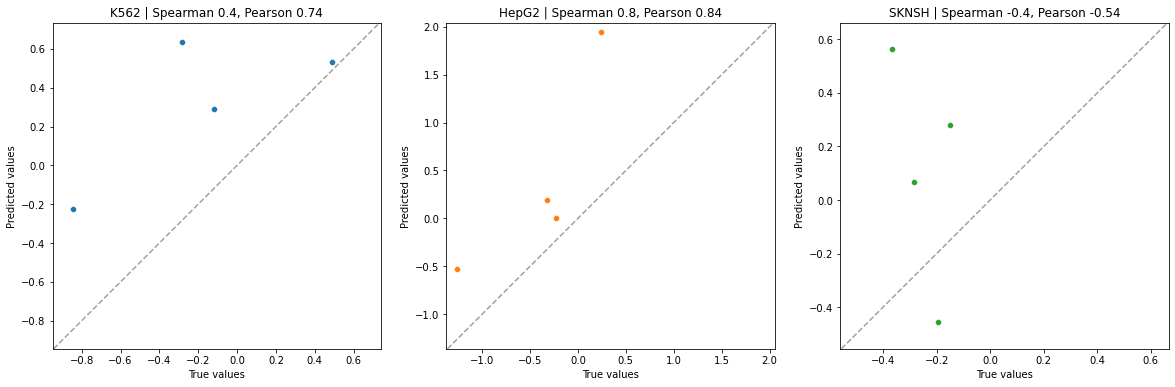

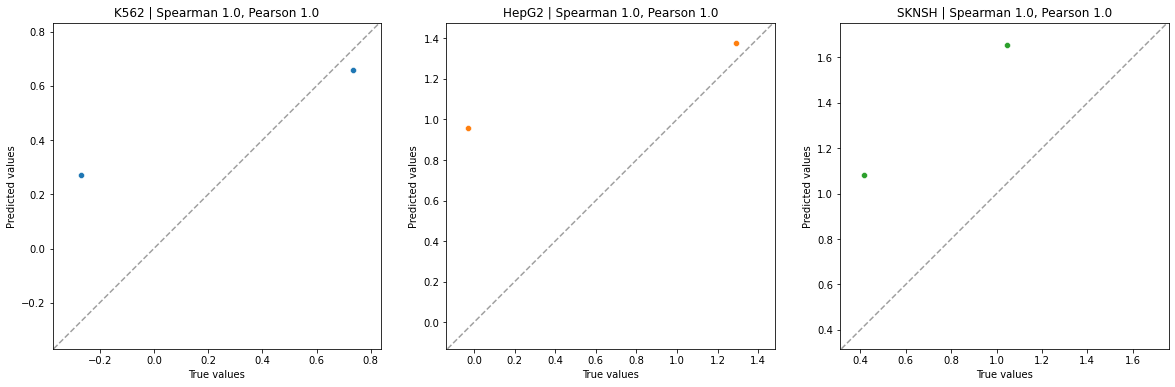

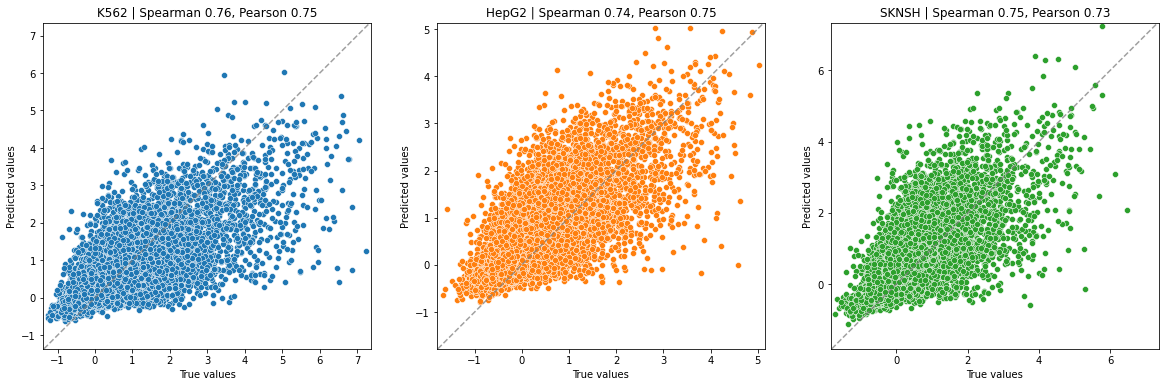

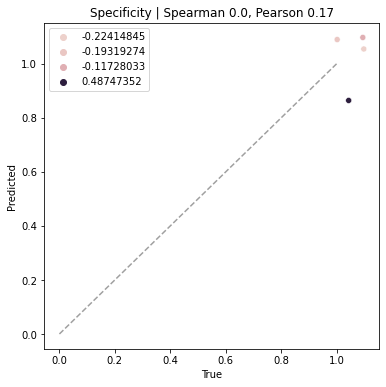

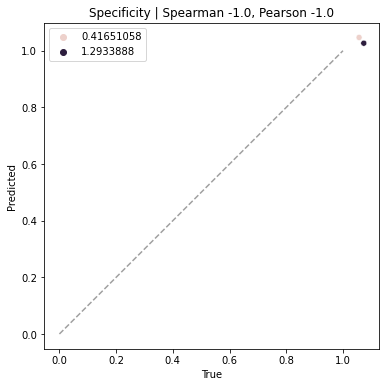

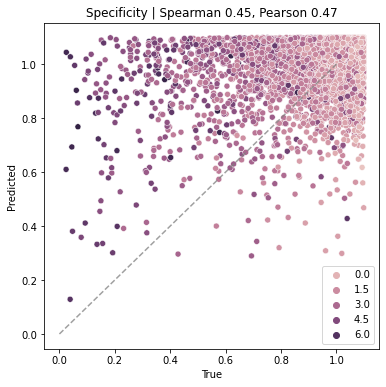

In [8]:
train_truths, train_preds = get_predictions(my_model, datamodule, dataset='synth_train')
val_truths, val_preds = get_predictions(my_model, datamodule, dataset='synth_val')
test_truths, test_preds = get_predictions(my_model, datamodule, dataset='synth_test')
get_scatterplots(train_truths, train_preds)
get_scatterplots(val_truths, val_preds)
get_scatterplots(test_truths, test_preds)
get_specificity_corr(torch.tensor(train_truths), torch.tensor(train_preds), specificity_fn=boda.graph.utils.shannon_entropy)
get_specificity_corr(torch.tensor(val_truths), torch.tensor(val_preds), specificity_fn=boda.graph.utils.shannon_entropy)
get_specificity_corr(torch.tensor(test_truths), torch.tensor(test_preds), specificity_fn=boda.graph.utils.shannon_entropy)

In [9]:
calc_hrfi(torch.tensor(test_truths), torch.tensor(test_preds), t_cutoff=0.4, p_cutoff=.4, transform_fn=boda.graph.utils.shannon_entropy)

{'hit_rate_fold_improvement': 43.74532699584961,
 'recovery_rate': 0.05202312138728324,
 'truths_hit_rate': 0.012102133594453335,
 'preds_hit_rate': 0.529411792755127,
 'truths_hit_count': 173,
 'truths_passed': 14295,
 'preds_hit_count': 9,
 'preds_passed': 17}


----------------------------------------------
Pearsons: [0.9636675734874809, 0.9664672769427671, 0.9633913667369054], average: 0.96
Spearmans: [0.8808117851053047, 0.9171478232984326, 0.9142989383770246], average: 0.9
----------------------------------------------

----------------------------------------------
Pearsons: [0.8919593258909743, 0.8837833552946747, 0.8873875699600507], average: 0.89
Spearmans: [0.8109784362377142, 0.8303278942361404, 0.834663320989255], average: 0.83
----------------------------------------------

----------------------------------------------
Pearsons: [0.8640870334602632, 0.8596434959282696, 0.8572845706298295], average: 0.86
Spearmans: [0.7658733740750626, 0.8016800633231523, 0.8040708543695506], average: 0.79
----------------------------------------------


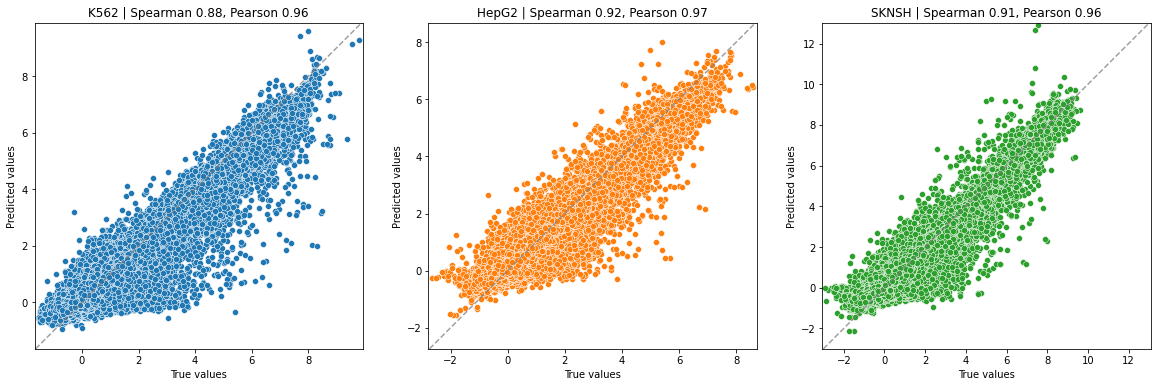

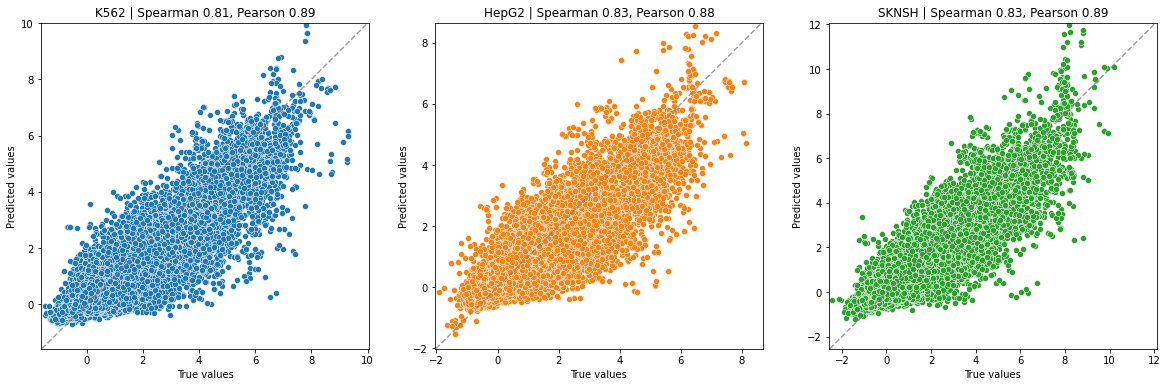

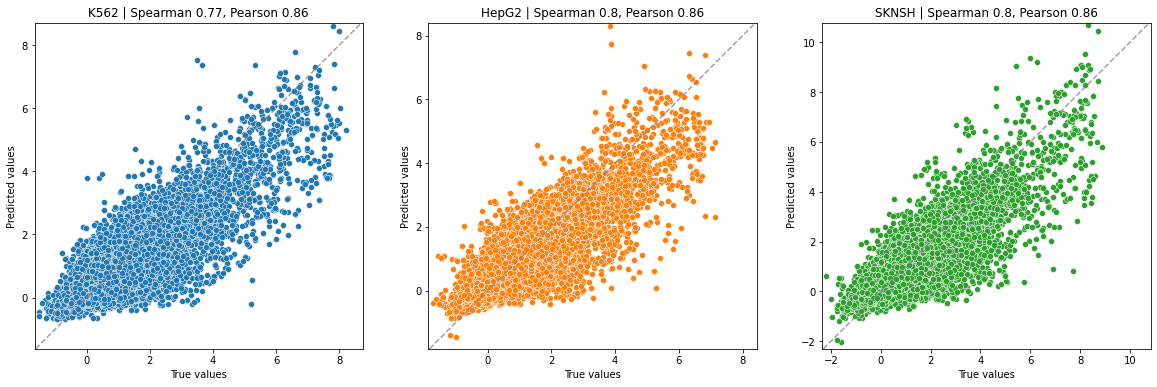

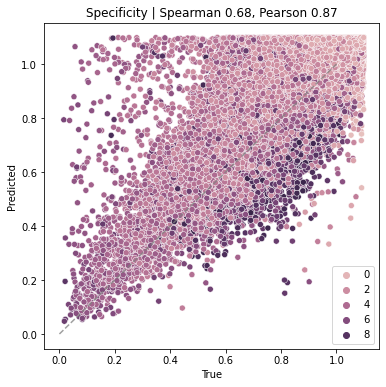

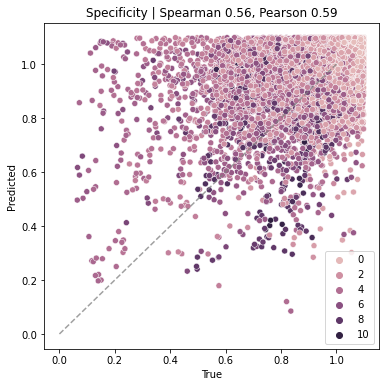

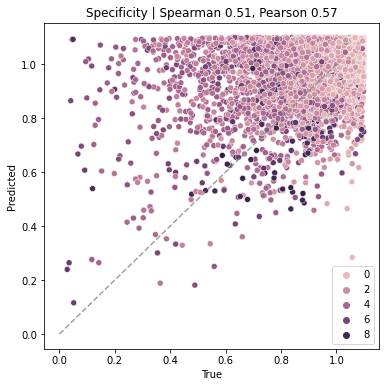

In [10]:
train_truths, train_preds = get_predictions(my_model, datamodule, dataset='chr_train')
val_truths, val_preds = get_predictions(my_model, datamodule, dataset='chr_val')
test_truths, test_preds = get_predictions(my_model, datamodule, dataset='chr_test')
get_scatterplots(train_truths, train_preds)
get_scatterplots(val_truths, val_preds)
get_scatterplots(test_truths, test_preds)
get_specificity_corr(torch.tensor(train_truths), torch.tensor(train_preds), specificity_fn=boda.graph.utils.shannon_entropy)
get_specificity_corr(torch.tensor(val_truths), torch.tensor(val_preds), specificity_fn=boda.graph.utils.shannon_entropy)
get_specificity_corr(torch.tensor(test_truths), torch.tensor(test_preds), specificity_fn=boda.graph.utils.shannon_entropy)

In [11]:
calc_hrfi(torch.tensor(val_truths), torch.tensor(val_preds), t_cutoff=0.3, p_cutoff=.3, transform_fn=boda.graph.utils.shannon_entropy)

{'hit_rate_fold_improvement': 150.75094604492188,
 'recovery_rate': 0.08737864077669903,
 'truths_hit_rate': 0.002595700789242983,
 'preds_hit_rate': 0.3913043439388275,
 'truths_hit_count': 103,
 'truths_passed': 39681,
 'preds_hit_count': 9,
 'preds_passed': 23}

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


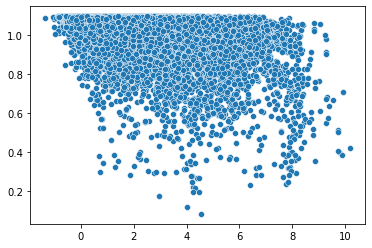

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


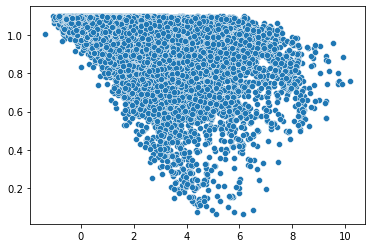

In [12]:
sns.scatterplot( torch.tensor(val_truths).max(1)[0], boda.graph.utils.shannon_entropy(torch.tensor(val_preds)) )
plt.show()
sns.scatterplot( torch.tensor(val_truths).max(1)[0], boda.graph.utils.shannon_entropy(torch.tensor(val_truths)) )
plt.show()


In [13]:
from boda.common.utils import generate_all_onehots, KmerFilter

In [14]:
sixmers = KmerFilter(6)
sixmers.cuda()

KmerFilter()

In [15]:
#for seq, vals in datamodule.val_dataloader():
#    res = sixmers(seq.cuda())
#    break

In [16]:
#res.max(dim=2)[0].sum(dim=1)

In [17]:
torch.save(my_model.state_dict(), '/tmp/temp_model.pkl' )